# Initializations

> Weights should be initialized apropriately

Adapted from:

- [https://www.youtube.com/watch?v=vGsc_NbU7xc&t=129s](https://www.youtube.com/watch?v=vGsc_NbU7xc&t=129s)

In [1]:
# |default_exp initializations

In [2]:
# |export
import math
from functools import partial

import fastcore.all as fc
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from einops import rearrange
from torch import nn, tensor
from torch.nn import init
from torchmetrics.classification import MulticlassAccuracy

from slowai.activations import (
    Conv2dWithReLU,
    Hook,
    HooksCallback,
    StoreModuleStatsCB,
    set_seed,
)
from slowai.convs import to_device
from slowai.learner import (
    Callback,
    DeviceCB,
    LRFinderCB,
    MetricsCB,
    MomentumCB,
    ProgressCB,
    TrainLearner,
    fashion_mnist,
    to_cpu,
)

In [3]:
set_seed(42)
plt.style.use("ggplot")

## Probability, misc

| Topic | Description | Formula |
|---|---|---|
| Average Error | Typically 0 because positive and negative errors cancel out, making this metric not useful. | $ \epsilon = \frac{1}{n} \sum y_{true} - y_{pred} $ |
| Variance | The expected value of the squared deviation from the mean of a random variable. | $\sigma^2 = \sum \frac{(x-\mathbb{E}[X])^2}{N}$ <br> $\sigma^2 = \mathbb{E}[X^2] - \mathbb{E}[X]^2$ |
| Covariance | A measure of the joint variability of two random variables. | $\operatorname{cov}(X,Y) = \operatorname{E}{\big[(X - \operatorname{E}[X])(Y - \operatorname{E}[Y])\big]}$ |
| Pearson Correlation Coefficient | A normalized measure of the linear relationship between two variables. | $\rho_{X,Y}= \frac{\operatorname{cov}(X,Y)}{\sigma_X \sigma_Y}$ |

## Baseline

Let's look at a fashion MNIST classification problem. Our goal is to get accuracy to at least 90%.

In [4]:
class CNN(nn.Module):
    """Six layer convolutional neural network"""

    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            Conv2dWithReLU(1, 8, kernel_size=5, stride=2, padding=2),  # 14x14
            Conv2dWithReLU(8, 16, kernel_size=3, stride=2, padding=1),  # 7x7
            Conv2dWithReLU(16, 32, kernel_size=3, stride=2, padding=1),  # 4x4
            Conv2dWithReLU(32, 64, kernel_size=3, stride=2, padding=1),  # 2x2
            nn.Conv2d(64, 10, kernel_size=3, stride=2, padding=1),  # 1x1
        )

    def forward(self, x):
        x = self.layers(x)
        return rearrange(x, "bs c w h -> bs (c w h)")

Let's start by finding the learning rate.

This diverges very quickly

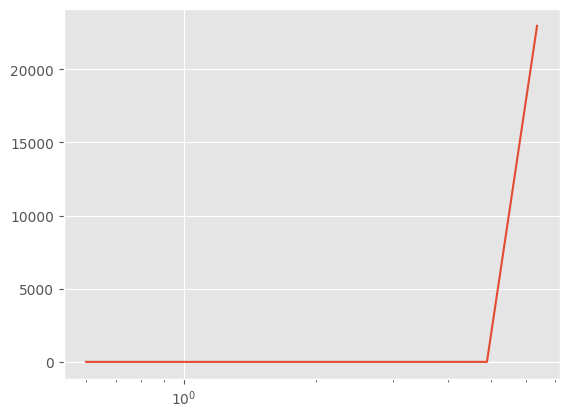

In [5]:
TrainLearner(
    CNN(),
    fashion_mnist(),
    F.cross_entropy,
    lr=0.6,
    cbs=[LRFinderCB(), MomentumCB()],
).fit()

That's unusable. Let's dial down the learning rate increase and start at a lower learning rate.

In [6]:
LRFinderCB?

Init signature: LRFinderCB(gamma=1.3, max_mult=3)
Docstring:     
Find an apopriate learning rate by increasing it by a constant factor for each batch
until the loss diverges
File:           ~/Desktop/SlowAI/nbs/slowai/learner.py
Type:           type
Subclasses:     

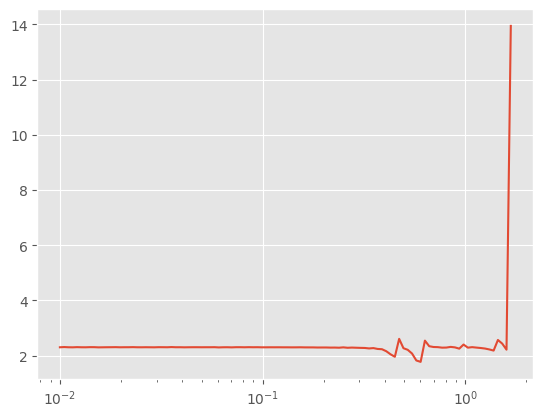

In [7]:
TrainLearner(
    CNN(),
    fashion_mnist(64),
    F.cross_entropy,
    lr=1e-2,
    cbs=[LRFinderCB(gamma=1.05), MomentumCB()],
).fit()

MulticlassAccuracy,loss,epoch,train
0.168,2.378,0,train
0.100,2.301,0,eval
0.203,2.170,1,train
0.489,1.624,1,eval


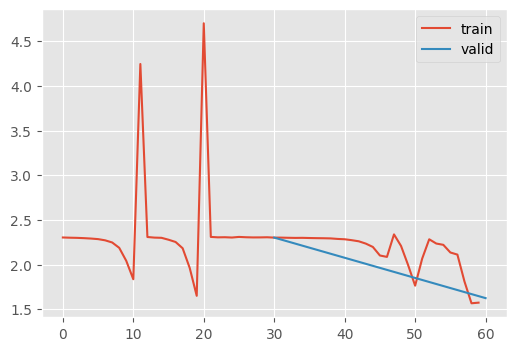

In [8]:
model = CNN()
stats = StoreModuleStatsCB(mods=model.layers)
cbs = [
    MomentumCB(),
    MetricsCB(MulticlassAccuracy(num_classes=10)),
    DeviceCB(),
    ProgressCB(plot=True),
    stats,
]
TrainLearner(
    model,
    fashion_mnist(),
    F.cross_entropy,
    lr=0.6,
    cbs=cbs,
).fit(2)

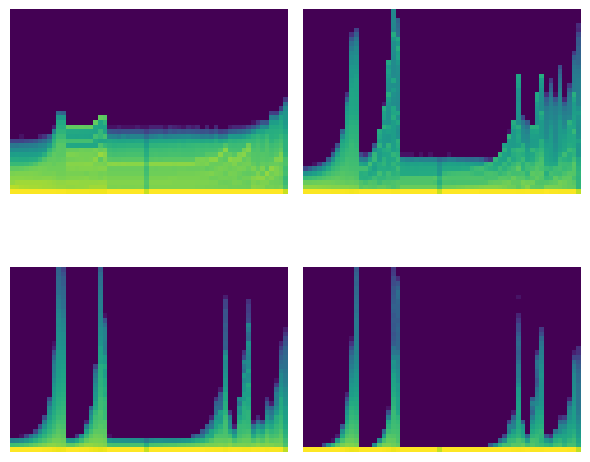

In [9]:
stats.hist_plot()

The issue with neural networks in real life is that they must be represented by discrete data structures. These can overflow...

In [10]:
x = torch.randn(200, 100)
for i in range(50):
    x = x @ torch.randn(100, 100)
x[0:5, 0:5]

tensor([[nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan]])

...or underflow..

In [11]:
x = torch.randn(200, 100)
for i in range(50):
    x = x @ torch.randn(100, 100) * 0.01
x[0:5, 0:5]

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

We should scale our weights such that, throughout the training process, the mean remains near 0 and the standard deviation remains near 1. Otherwise, we are suseptible to these "dead units"

## Glorot/Xavier

Normally, the mean variance of a layer is approximately the number of output dimensions

In [12]:
for d in [1, 100]:
    means = []
    sqrs = []

    for _ in range(500):
        x = torch.randn(d)
        a = torch.randn(512, d)
        y = a @ x
        means.append(y.mean())
        sqrs.append(y.pow(2).mean())

    res = torch.stack(means).mean(), torch.stack(sqrs).mean()
    print(res)

(tensor(-0.0011), tensor(1.1372))
(tensor(-0.0029), tensor(100.2205))




To encourage of variance of 1, the paper from Xavier Glorot and Yoshua Bengio proposed that each layer have a coefficient of $\frac{1}{\sqrt{d}}$ where $d$ is the number of inputs

In [13]:
d = 100
x = torch.randn(200, d)
for i in range(50):
    layer = torch.randn(d, d) * (1 / math.sqrt(d))
    x = x @ layer
x[0:5, 0:5]

tensor([[ 1.7367, -0.3418, -2.1874, -0.9467,  1.0451],
        [ 0.7802,  0.3702, -0.9278,  0.1607,  0.7578],
        [-2.0552,  1.0210,  1.7889,  0.1260, -1.0092],
        [-0.4922, -0.1349,  0.0443, -0.3037, -0.1711],
        [ 0.0103,  0.0468, -0.6201, -1.1773,  0.1258]])

Indeed, this gives us reasonable numbers! However, this doesn't work for modern deep learning because of the **activation layers**.


## Kaiming/He init

Notice that the first layer of a neural network has a favorable activation distribution

In [14]:
d1, d2 = 100, 100
x = torch.randn(200, d1)
y = torch.randn(200)
w = torch.randn(d1, d2) / math.sqrt(d1)
b = torch.zeros(d2)

In [15]:
l1 = x @ w + b
l1.mean(), l1.std()

(tensor(0.0034), tensor(0.9888))

But what happens when we add non-linearities?

In [16]:
def relu(x):
    return x.clamp_min(0.0)


l1r = relu(l1)
l1r.mean(), l1r.std()

(tensor(0.3943), tensor(0.5795))

Indeed, this property is lost...thus goes the path to ruin...

In [17]:
l = l1r
for _ in range(50):
    w = torch.randn(d2, d2) * math.sqrt(1 / d2)
    l = relu(l @ w)
l[0:5, 0:5]

tensor([[3.6994e-08, 0.0000e+00, 9.4013e-09, 1.5577e-08, 1.0590e-08],
        [5.5068e-08, 0.0000e+00, 1.1871e-08, 2.4266e-08, 1.3567e-08],
        [9.3161e-08, 0.0000e+00, 2.2955e-08, 4.0294e-08, 2.4063e-08],
        [4.9314e-08, 0.0000e+00, 1.1283e-08, 2.1542e-08, 1.3132e-08],
        [3.8813e-08, 0.0000e+00, 9.7021e-09, 1.6069e-08, 1.1153e-08]])

To rectify this situation, Kaiming proposed using $\sqrt{\frac{2}{d}}$

In [18]:
l = l1r
for _ in range(50):
    w = torch.randn(d2, d2) * math.sqrt(2 / d2)
    l = relu(l @ w)
l[0:5, 0:5]

tensor([[0.0218, 0.0350, 0.0000, 0.4040, 0.0000],
        [0.1481, 0.0000, 0.0000, 0.5991, 0.0000],
        [0.0582, 0.1006, 0.0000, 0.7180, 0.0162],
        [0.1623, 0.0000, 0.0000, 0.9592, 0.0000],
        [0.1217, 0.0169, 0.0000, 0.6792, 0.0000]])

Notice, there are still positive numbers even after 50 layers!

This is the best way to initialize a network. But how do we do this on a code level? We use the `.apply()` method.

In [19]:
def init_weights(module):
    # `kaiming_normal_` is an in-place operation, unlike `kaiming_normal`
    if not isinstance(module, (nn.Sequential, Conv2dWithReLU, CNN)):
        init.kaiming_normal_(module.weight)

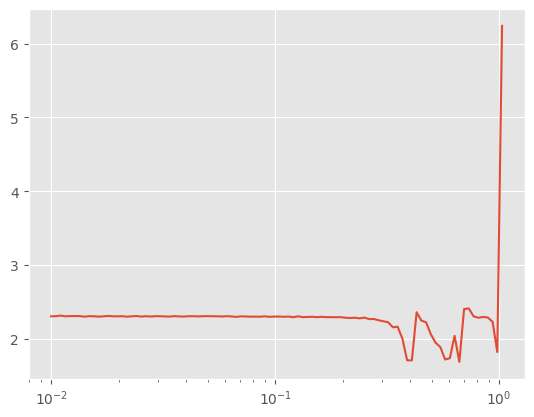

In [20]:
model = CNN()
model.apply(init_weights)
learn = TrainLearner(
    CNN(),
    fashion_mnist(64),
    F.cross_entropy,
    lr=1e-2,
    cbs=[LRFinderCB(gamma=1.05), MomentumCB()],
).fit()

Better! Let's try training with 0.25.

MulticlassAccuracy,loss,epoch,train
0.549,1.430,0,train
0.673,0.951,0,eval
0.749,0.665,1,train
0.752,0.646,1,eval


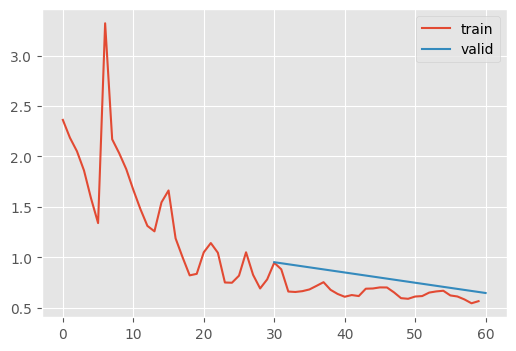

In [21]:
model = CNN()
model.apply(init_weights)
stats = StoreModuleStatsCB(mods=model.layers)
cbs = [
    MetricsCB(MulticlassAccuracy(num_classes=10)),
    DeviceCB(),
    ProgressCB(plot=True),
    MomentumCB(),
    stats,
]
TrainLearner(
    model,
    fashion_mnist(),
    F.cross_entropy,
    lr=0.25,
    cbs=cbs,
).fit(2)

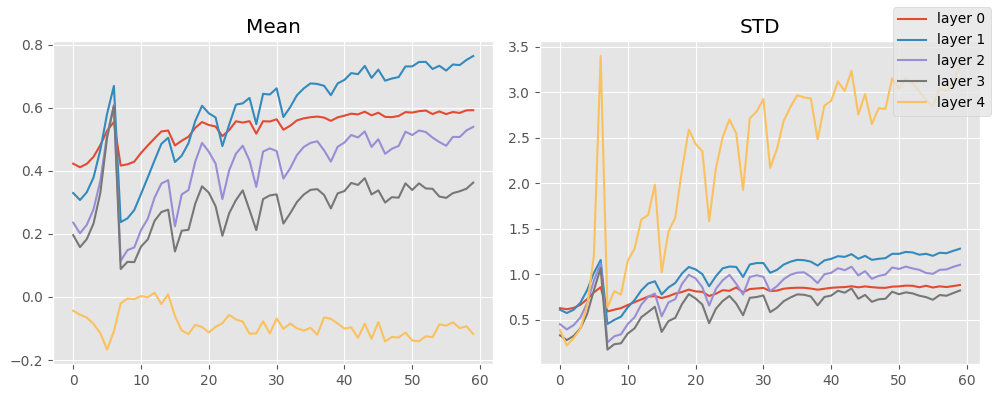

In [22]:
stats.mean_std_plot()

That's okay! Keep in mind, I did globally normalize the inputs.

Let's try normalizing batchwise.

In [23]:
# |export
class BatchTransformCB(Callback):
    """Arbitrarily transform a batch"""

    def __init__(self, tfm, on_train=True, on_val=True):
        fc.store_attr()

    def before_batch(self, learn):
        if (self.on_train and learn.training) or (self.on_val and not learn.training):
            learn.batch = self.tfm(learn.batch)

In [24]:
# |export
class NormalizeBatchCB(BatchTransformCB):
    """Unit normalize a batch"""

    def __init__(self, on_train=True, on_val=True):
        fc.store_attr()

    def tfm(self, batch):
        xb, *other = batch
        mu = xb.mean()
        sigma = xb.std()
        return (xb - mu) / sigma, *other

MulticlassAccuracy,loss,epoch,train
0.549,1.398,0,train
0.706,0.823,0,eval
0.758,0.665,1,train
0.769,0.799,1,eval


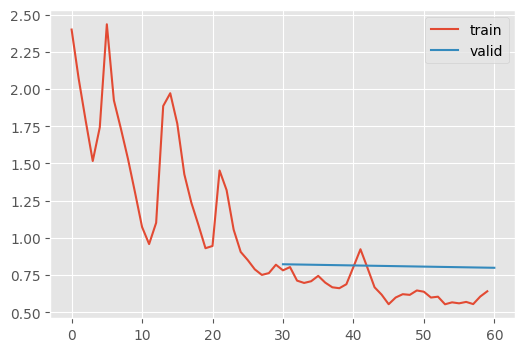

In [25]:
model = CNN()
model.apply(init_weights)
stats = StoreModuleStatsCB(mods=model.layers)
dls = fashion_mnist()
cbs = [
    MetricsCB(MulticlassAccuracy(num_classes=10)),
    DeviceCB(),
    ProgressCB(plot=True),
    NormalizeBatchCB(),
    MomentumCB(),
    stats,
]
learn = TrainLearner(
    model,
    dls,
    F.cross_entropy,
    lr=0.25,
    cbs=cbs,
)
learn.fit(2)

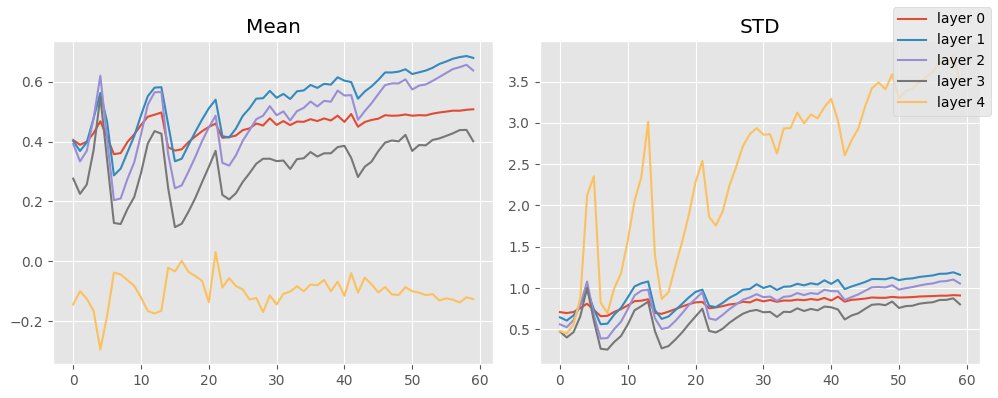

In [26]:
stats.mean_std_plot()

This isn't much better, unsurprisingly since it was already normalized.

## Why aren't these activation distributions unit normal? 

The problem is that `StoreModuleStatsCB` looks at the **output** of the ReLU + Convolutional blocks, which cannot output negative numbers (except for the last layer which does not have an non-linearity). Therefore, their output **cannot** look unit normal!

What if we modified ReLU to allow unit normality?

$$
\text{GeneralReLU}_{l,r,m}(x) = min(\{m, 
\left.
  \begin{cases}
    x & \text{if } x > 0 \\
    l \cdot x & \text{otherwise}
  \end{cases}
  \right\} - r
\})
$$

In [27]:
# |export
class GeneralReLU(nn.Module):
    """Generalized ReLU activation function with normalization and leakiness"""
    def __init__(self, leak=None, sub=None, max_=None):
        super().__init__()
        self.leak = leak
        self.sub = sub
        self.max_ = max_

    def forward(self, x):
        if self.leak:
            x = F.leaky_relu(x, self.leak)
        else:
            x = F.relu(x)
        if self.sub:
            x -= self.sub
        if self.max_:
            x.clamp_max_(self.max_)
        return x

This should output a roughly unit normal distribution by pushing all the values down and allowing some contribution from negative values.

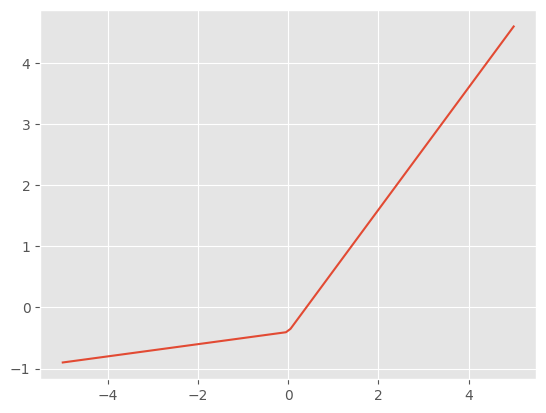

In [28]:
x = torch.linspace(-5, 5, steps=100)
gr = GeneralReLU(leak=0.1, sub=0.4)
plt.plot(x, gr(x));

In [29]:
C = Conv2dWithReLU


class CNNWithGeneralReLU(nn.Module):
    """Six layer convolutional neural network with GeneralRelU"""

    def __init__(self, gr=lambda: GeneralReLU(leak=0.1, sub=0.4)):
        super().__init__()
        layers = [  #
            C(1, 8, kernel_size=5, stride=2, padding=2, nonlinearity=gr()),  # 14x14
            C(8, 16, 3, 2, 1, nonlinearity=gr()),  # 7x7
            C(16, 32, 3, 2, 1, nonlinearity=gr()),  # 4x4
            C(32, 64, 3, 2, 1, nonlinearity=gr()),  # 2x2
            nn.Conv2d(64, 10, 3, 2, 1),  # 1x1
        ]
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        *_, w, h = x.shape
        assert w == h == 1
        return rearrange(x, "bs c w h -> bs (c w h)")

⚠️ Now that we are no longer using ReLU outputs, so Kaiming initialization is not acceptable! Luckily, there is an adjustment for this leaky property in the pytorch script

In [30]:
# |export
def init_leaky_weights(module, leak=0.0):
    if isinstance(module, (nn.Conv2d,)):
        init.kaiming_normal_(module.weight, a=leak)  # 👈 weirdly, called `a` here

MulticlassAccuracy,loss,epoch,train
0.656,0.996,0,train
0.762,0.640,0,eval
0.789,0.573,1,train
0.761,0.663,1,eval


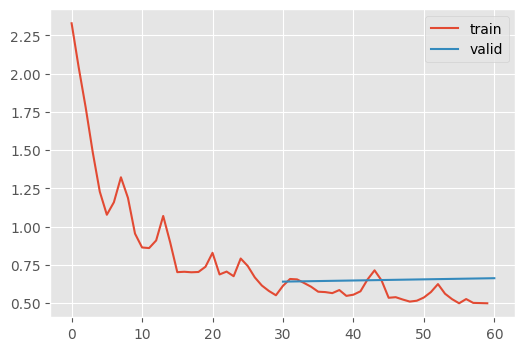

In [31]:
leak = 0.1
model = CNNWithGeneralReLU(gr=lambda: GeneralReLU(leak=leak, sub=0.4))
model.apply(partial(init_leaky_weights, leak=leak))
stats = StoreModuleStatsCB(mods=model.layers)
cbs = [
    MetricsCB(MulticlassAccuracy(num_classes=10)),
    DeviceCB(),
    ProgressCB(plot=True),
    NormalizeBatchCB(),
    MomentumCB(),
    stats,
]
learn = TrainLearner(
    model,
    fashion_mnist(),
    F.cross_entropy,
    lr=0.25,
    cbs=cbs,
)
learn.fit(2)

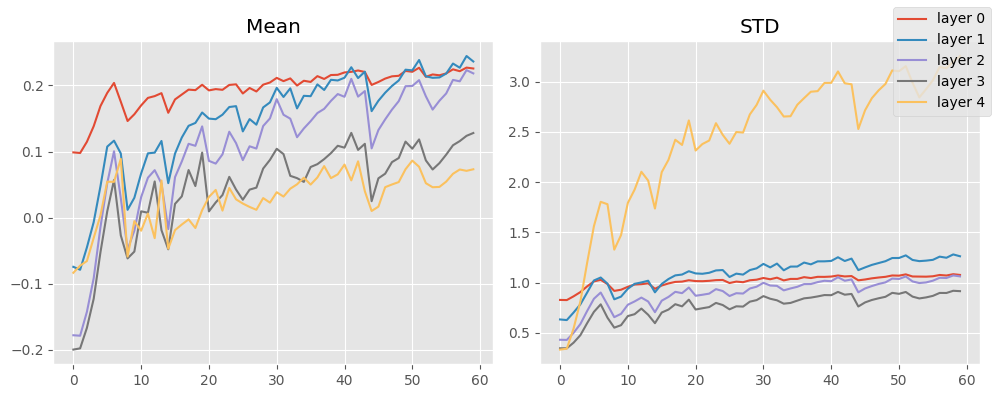

In [32]:
stats.mean_std_plot()

That looks **GREAT** 🤩 What happens if we keep on training that?

In [33]:
learn.fit(10)

86% accuracy! Not bad.

This goes to show that initialization is underappreciated.

## General Initializations

"All You Need Is a Good Init" proposed that there is a generic strategy to initialize any model.

- Setup your model any way you like
- Pass a batch of data through the model and record the layer wise activation statistics
- Apply a unit normalization
- Repeat step 2 until the activation statistics are unit normal within an acceptable tolerance

In code:

In [34]:
# |export
class LSUVHook(Hook):
    """An abstract hook for performing LSUV for a single layer. `.normalize()`
    needs to be implemented for the specific layers"""

    def __init__(self, m, tol=1e-3):
        self.mean = None
        self.std = None
        self.tol = tol

        def append_moments(module, _, activations):
            activations = to_cpu(activations)
            self.mean = activations.mean()
            self.std = activations.std()

        self.hook = m.register_forward_hook(append_moments)
        self.m = m

    def normalized(self):
        assert self.mean and self.std, "Attempted normalization before processing data"
        return abs(self.mean) <= self.tol and abs(self.std - 1) <= self.tol

    def normalize(self):
        raise NotImplementedError

In [35]:

class CNNLSUVHook(LSUVHook):
    def normalize(self):
        if isinstance(self.m, (nn.Conv2d)):
            # Final layer
            self.m.bias -= self.mean
            self.m.weight.data /= self.std
        else:
            self.m.conv.bias -= self.mean
            self.m.conv.weight.data /= self.std

In [36]:
# |export
class LSUVInitialization(HooksCallback):
    """Layer wise sequential unit variance initialization"""

    def __init__(
        self,
        mods=None,
        mod_filter=fc.noop,
        on_train=True,
        on_valid=False,
        hook_cls=LSUVHook,
    ):
        fc.store_attr()

    def before_fit(self, learn):
        try:
            trn = learn.dls["train"]
            xb, *_ = next(iter(trn))
            xb = to_device(xb)
            super().before_fit(learn)
            with torch.no_grad():
                for i, h in enumerate(self.hooks):
                    for n_batches in range(1_000):
                        learn.model(xb)
                        if not h.normalized():
                            h.normalize()
                        else:
                            print(
                                f"Layer {i} normalized after {n_batches} batches ({h.mean:.2f}, {h.std:.2f})"
                            )
                            break
                    else:
                        raise ValueError("Initialization failed!")
        finally:
            # We don't need these hooks anymore, so we can get rid of them
            # before beginning training
            self.cleanup_fit(learn)
            self.hooks = []

Layer 0 normalized after 36 batches (0.00, 1.00)
Layer 1 normalized after 37 batches (0.00, 1.00)
Layer 2 normalized after 35 batches (0.00, 1.00)
Layer 3 normalized after 37 batches (0.00, 1.00)
Layer 4 normalized after 2 batches (-0.00, 1.00)


MulticlassAccuracy,loss,epoch,train
0.515,1.553,0,train
0.611,1.258,0,eval
0.710,0.928,1,train
0.749,0.779,1,eval


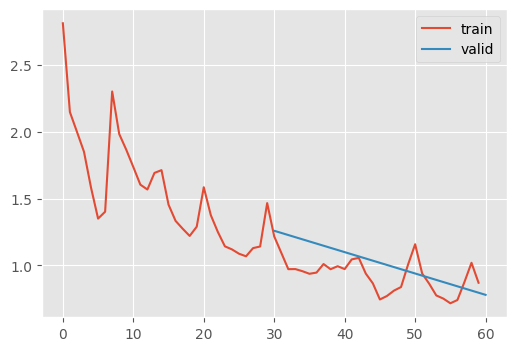

In [37]:
leak = 0.1
model = CNNWithGeneralReLU(gr=partial(GeneralReLU, leak=leak))

# Note that we're removing the `model.apply` in favor of LSUVInitialization

stats = StoreModuleStatsCB(mods=model.layers)
cbs = [
    MetricsCB(MulticlassAccuracy(num_classes=10)),
    DeviceCB(),
    ProgressCB(plot=True),
    NormalizeBatchCB(),
    MomentumCB(),
    LSUVInitialization(mods=model.layers, hook_cls=CNNLSUVHook),
    stats,
]
learn = TrainLearner(
    model,
    dls,
    F.cross_entropy,
    lr=0.25,
    cbs=cbs,
)
learn.fit(2)

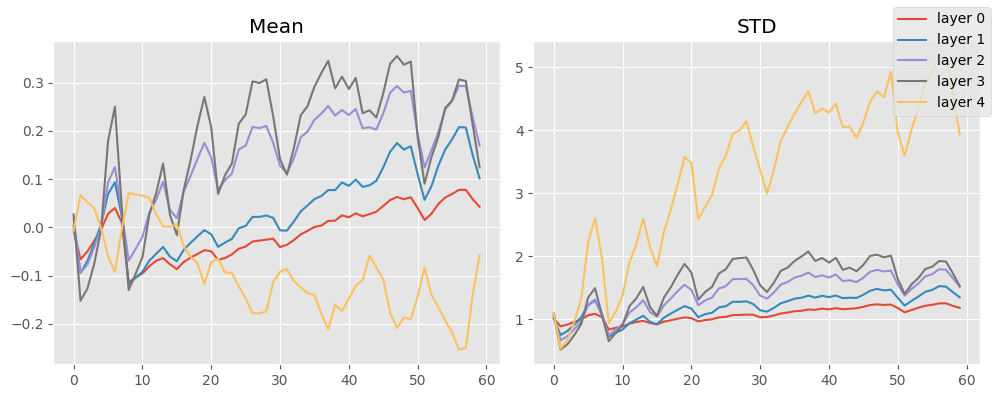

In [38]:
stats.mean_std_plot()

That's the most accurate yet! The moments look __perfect__.

## Batch and layer normalization

We have been normalizing the inputs before training, but the input distribution can change during training. This is known as **internal covariate shift**. Can we compensate?

Indeed, we can simply normalize as part of the model architecture

### LayerNorm

Proposed one year after BatchNorm by Hinton, but simpler so we'll start with that. Quite simply implemented like so

In [39]:
class LayerNorm(nn.Module):
    def __init__(self, eps=1e-5):
        super().__init__()
        self.k = nn.Parameter(torch.tensor(1.0))
        self.a = nn.Parameter(torch.tensor(0.0))
        self.eps = eps

    def forward(self, x):
        m = x.mean((1, 2, 3), keepdim=True)
        v = x.var((1, 2, 3), keepdim=True)
        x = (x - m) / ((v + self.eps).sqrt())
        return x

Jeremy notes that:

- Although epsilon is used commonly to correct for the "dead unit" issue, you should not rely on the defaults. Often, they are too small.
- This is not really a "normalization" because `k` and `a` can be anything; the network is learning the apropriate distribution moments -- and perhaps this is easier for the network

In [40]:
# |export
class Conv2dGeneral(nn.Module):
    """Convolutional neural network with a built in activation"""

    @fc.delegates(nn.Conv2d)
    def __init__(
        self,
        *args,
        nonlinearity=F.relu,
        norm=None,
        **kwargs,
    ):
        super().__init__()
        self.conv = nn.Conv2d(*args, **kwargs)
        self.nonlinearity = nonlinearity
        self.norm = norm

        if not isinstance(self.norm, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d)):
            bias = getattr(self.conv, "bias", None)
            assert (
                bias is not None
            ), "Convolutional layer should have a bias if it does not use batchnorm"

    def forward(self, x):
        x = self.conv(x)
        if self.nonlinearity:
            x = self.nonlinearity(x)
        if self.norm:
            x = self.norm(x)
        return x

In [41]:
# |export
C = Conv2dGeneral

In [42]:
class CNNWithGeneralReLUAndLayerNorm(nn.Module):
    """Six layer convolutional neural network with GeneralRelU"""

    def __init__(self, gr=GeneralReLU, norm=LayerNorm):
        super().__init__()
        layers = [
            C(1, 8, kernel_size=5, stride=2, padding=2, nonlinearity=gr(), norm=norm()),
            C(8, 16, 3, 2, 1, nonlinearity=gr(), norm=norm()),
            C(16, 32, 3, 2, 1, nonlinearity=gr(), norm=norm()),
            C(32, 64, 3, 2, 1, nonlinearity=gr(), norm=norm()),
            nn.Conv2d(64, 10, 3, 2, 1),  # 1x1
        ]
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        *_, w, h = x.shape
        assert w == h == 1
        return rearrange(x, "bs c w h -> bs (c w h)")

MulticlassAccuracy,loss,epoch,train
0.666,0.985,0,train
0.779,0.621,0,eval
0.819,0.501,1,train
0.801,0.561,1,eval


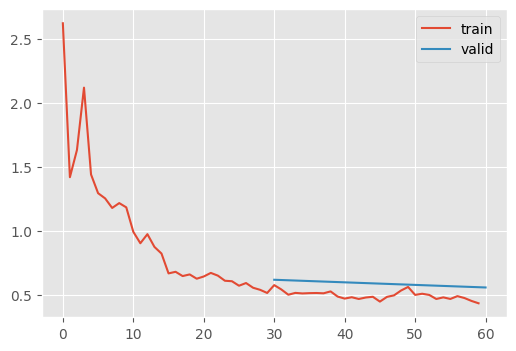

In [43]:
leak = 0.1
model = CNNWithGeneralReLUAndLayerNorm(gr=partial(GeneralReLU, leak=leak))
model.apply(partial(init_leaky_weights, leak=leak))
stats = StoreModuleStatsCB(mods=model.layers)
cbs = [
    MetricsCB(MulticlassAccuracy(num_classes=10)),
    DeviceCB(),
    ProgressCB(plot=True),
    NormalizeBatchCB(),
    MomentumCB(),
    stats,
]
learn = TrainLearner(
    model,
    dls,
    F.cross_entropy,
    lr=0.25,
    cbs=cbs,
)
learn.fit(2)

Even more accurate, by a bit.

While this does help, it turns out that `BatchNorm` and `LayerNorm` introduces complixities that have led to me lose favor recently. This just means that the initialization is even more important, as a skill.

That being said, here's the code for BatchNorm.

In [44]:
# |export
class BatchNorm(nn.Module):
    """Batch normalization"""
    def __init__(self, num_filters, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom = mom
        self.eps = eps
        self.mults = nn.Parameter(torch.ones(num_filters, 1, 1))
        self.adds = nn.Parameter(torch.zeros(num_filters, 1, 1))

        # These need to be saved in the model
        self.register_buffer("vars", torch.ones(1, num_filters, 1, 1))
        self.register_buffer("means", torch.zeros(1, num_filters, 1, 1))

    def update_stats(self, x):
        bs, c, h, w = x.shape
        m = x.mean((0, 2, 3), keepdim=True)
        v = x.var((0, 2, 3), keepdim=True)

        # Update with an exponentially moving average
        self.means.lerp_(m, self.mom)
        self.vars.lerp_(v, self.mom)
        return m, v

    def forward(self, x):
        if self.training:
            with torch.no_grad():
                m, v = self.update_stats(x)
        else:
            m, v = self.means, self.vars
        x = (x - m) / (v + self.eps).sqrt()
        return x * self.mults + self.adds

What does `lerp_` do here?

In [45]:
momentum = 0.5
torch.lerp(tensor(1.0), tensor(2.0), tensor(momentum))

tensor(1.5000)

In [46]:
momentum = 0.3333
torch.lerp(tensor(1.0), tensor(2.0), tensor(momentum))

tensor(1.3333)

The basic idea is to normalize the batches accourding to the weighted average of the means and variances of the previous batches. Hopefully, this makes it such that if the model encounters a "weird" batch, it's not thrown off too much.

In [47]:
# |export
class CNNWithGeneralReLUAndBatchNorm(nn.Module):
    """Six layer convolutional neural network with GeneralRelU"""

    def __init__(self, gr=GeneralReLU):
        super().__init__()
        layers = [
            C(1, 8, 5, 2, 2, nonlinearity=gr(), norm=BatchNorm(8)),
            C(8, 16, 3, 2, 1, nonlinearity=gr(), norm=BatchNorm(16)),
            C(16, 32, 3, 2, 1, nonlinearity=gr(), norm=BatchNorm(32)),
            C(32, 64, 3, 2, 1, nonlinearity=gr(), norm=BatchNorm(64)),
            nn.Conv2d(64, 10, 3, 2, 1),  # 1x1
        ]
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        *_, w, h = x.shape
        assert w == h == 1
        return rearrange(x, "bs c w h -> bs (c w h)")

MulticlassAccuracy,loss,epoch,train
0.702,0.845,0,train
0.769,0.666,0,eval
0.817,0.503,1,train
0.806,0.556,1,eval


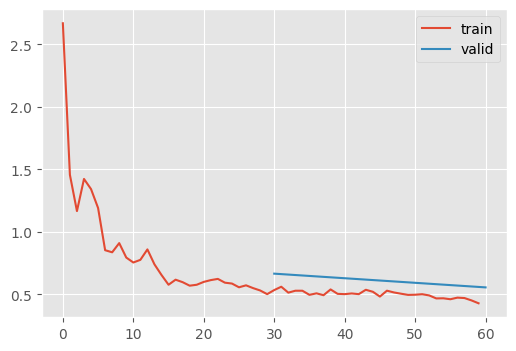

In [48]:
leak = 0.1
model = CNNWithGeneralReLUAndBatchNorm(gr=partial(GeneralReLU, leak=leak))
model.apply(partial(init_leaky_weights, leak=leak))
stats = StoreModuleStatsCB(mods=model.layers)
cbs = [
    MetricsCB(MulticlassAccuracy(num_classes=10)),
    DeviceCB(),
    ProgressCB(plot=True),
    NormalizeBatchCB(),
    MomentumCB(),
    stats,
]
learn = TrainLearner(
    model,
    dls,
    F.cross_entropy,
    lr=0.25,
    cbs=cbs,
)
learn.fit(2)

Just a tiny bit better, but that looks very smooth. Let's see if we can increase the learning rate.

MulticlassAccuracy,loss,epoch,train
0.419,1.934,0,train
0.172,193.459,0,eval
0.399,2.227,1,train
0.100,2.383,1,eval


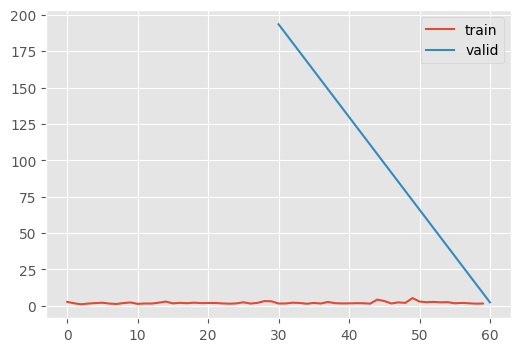

In [49]:
model = CNNWithGeneralReLUAndBatchNorm(gr=partial(GeneralReLU, leak=leak))
model.apply(partial(init_leaky_weights, leak=leak))
learn = TrainLearner(
    model,
    dls,
    F.cross_entropy,
    lr=0.4,
    cbs=cbs,
)
learn.fit(2)

Nope...

## Towards 90%

Let's try a few different things:

- Lower batch size
- Decrease learning rate (smaller batch sizes neccesitate lower learning rates) 
- Train for longer
- Finetune with an even lower learning rate

MulticlassAccuracy,loss,epoch,train
0.817,0.504,0,train
0.848,0.426,0,eval
0.870,0.356,1,train
0.862,0.385,1,eval
0.883,0.319,2,train
0.870,0.362,2,eval


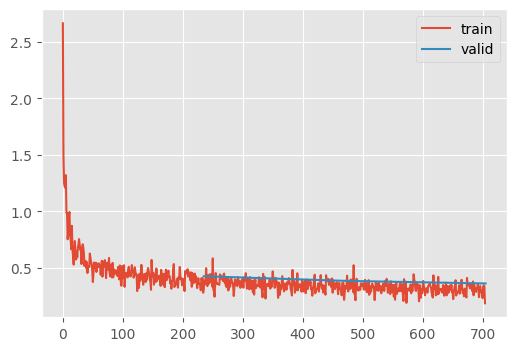

In [50]:
model = CNNWithGeneralReLUAndBatchNorm(gr=partial(GeneralReLU, leak=leak))
model.apply(partial(init_leaky_weights, leak=leak))
learn = TrainLearner(
    model,
    fashion_mnist(256),
    F.cross_entropy,
    lr=0.2,
    cbs=cbs,
)
learn.fit(3)

MulticlassAccuracy,loss,epoch,train
0.900,0.276,0,train
0.882,0.328,0,eval
0.903,0.267,1,train
0.886,0.324,1,eval


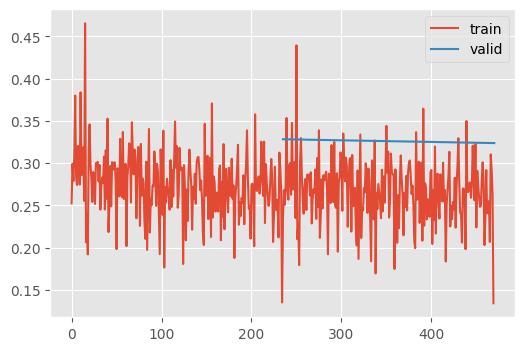

In [51]:
learn = TrainLearner(
    model,
    fashion_mnist(256),
    F.cross_entropy,
    lr=0.05,
    cbs=cbs,
)
learn.fit(2)

88%! So close. We'll get there in the next notebook.

In [1]:
#| hide
import nbdev

nbdev.nbdev_export()

/home/jeremy/micromamba/envs/slowai/lib/python3.11/site-packages/nbdev/export.py:73: UserWarning: Notebook '/home/jeremy/Desktop/SlowAI/nbs/hack.ipynb' uses `#|export` without `#|default_exp` cell.
Note nbdev2 no longer supports nbdev1 syntax. Run `nbdev_migrate` to upgrade.
See https://nbdev.fast.ai/getting_started.html for more information.
  warn(f"Notebook '{nbname}' uses `#|export` without `#|default_exp` cell.\n"
